**Deep Learning 2023/24 - Final Project**
===============

Prediction of Stock Prices
---------------

## Team:
- Lukas Weigmann
- Andre Datchev
- Hannes Pohnke

-----------------------------------

Outline
1. Preface/Intro/benchmark
2. Dataset
3. Data preparation
4. model 1
5. model 2 
6. model ...
7. Evaluation
8. Conclusion

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


## *1. Introduction*

## *Acquiring data*

----------------------------------

We will use yfinance to load the price histories of the Stocks we want to have.

[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2021-02-04  31.049999  31.080000  30.955000  31.025000  28.625145    5900
2021-02-05  31.160000  31.389999  31.049999  31.389999  28.961912   31200
2021-02-08  31.389999  31.480000  31.120001  31.355000  28.929619   13500
2021-02-09  31.365000  31.440001  31.240000  31.360001  28.934231    2800
2021-02-10  31.389999  31.472000  31.209999  31.287001  28.866880    4100 
 (754, 6) 

            Adj Close
Date                 
2021-02-04  28.625145
2021-02-05  28.961912
2021-02-08  28.929619
2021-02-09  28.934231
2021-02-10  28.866880
[[28.62514496]
 [28.96191216]
 [28.92961884]
 [28.9342308 ]
 [28.86688042]
 [28.98497772]
 [29.10030937]
 [29.11876106]
 [28.74047661]
 [28.66666222]
 [28.87887192]
 [28.83366585]
 [28.84196663]
 [29.08001137]
 [28.65743828]
 [28.39909744]
 [28.87887192]
 [28.92500496]
 [28.92500496]
 [28.58362389]
 [28.41754913]


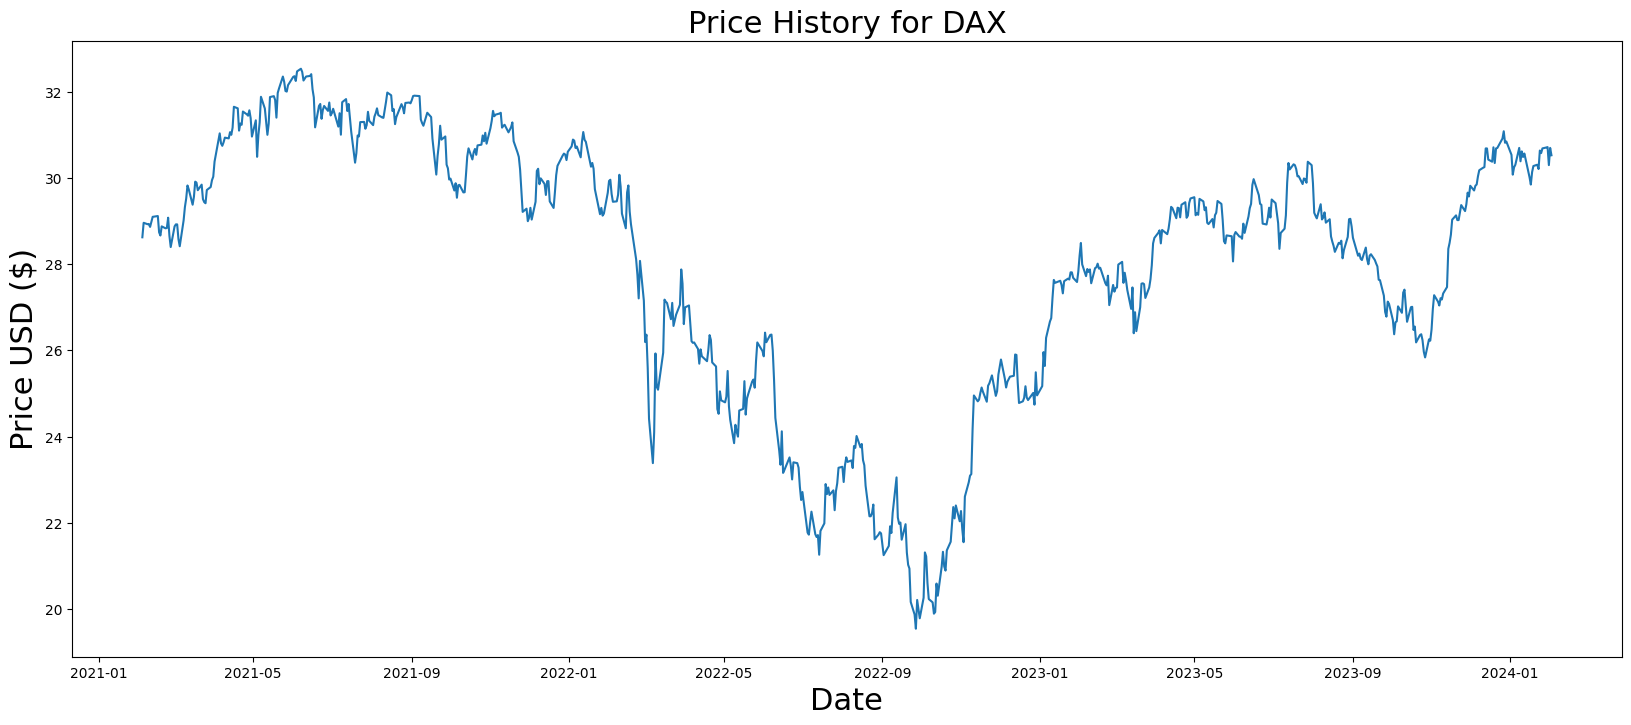

In [21]:
yf.pdr_override()
pd.set_option('display.max_rows', None)

#timeframe we want to load the data from in years
timeframe = 3

#setting end and start date 
end = datetime.now()
    #end = datetime(end .year - 1, end.month, end.day)
start = datetime(end.year - timeframe, end.month, end.day)

#how the downloaded dataframe looks
dax = pdr.get_data_yahoo("DAX", start, end)
print(dax.head(), "\n", dax.shape, "\n")

#extracting the price history
dax_history = dax.filter(["Adj Close"])
print(dax_history.head())
#interpolating the missing Values

#visulazing
def plot_history(history, index):
    plt.figure(figsize=(20,8))
    plt.title('Price History for ' + index, fontsize=22)
    plt.plot(history)
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Price USD ($)', fontsize=22)

    plt.show()
    
plot_history(dax_history, "DAX")


In [ ]:
# stock_data = PyTickerSymbols()
# 
# # Tickers for current dax companies
# # ! We'll only use current DAX companies (the size composition of the index changes through time)
# 
# dax_overview = stock_data.get_stocks_by_index('DAX') # this includes additional data like industry, number of employees but not super useful ig
# dax_tickers = [entry['symbol'] for entry in dax_overview]
# dax_tickers = [f"{ticker}.F" for ticker in dax_tickers] # F for Frankfurt tickers
# print(dax_tickers)
# 
# if 'DPW.F' in dax_tickers: 
#     dax_tickers[dax_tickers.index('DPW.F')] = 'DPWA.F' # seemingly PyTickerSymbols() doesnt know of this name change yet 


In [13]:
#loading more data
def load_histories(indices):
    stock_histories = []
    for index in indices :
        stock = pdr.get_data_yahoo(index, start, end)
        adj_close_history = stock['Adj Close']
        stock_histories.append(adj_close_history)
        
    return stock_histories

stocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', 'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', 'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', 'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', 'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']

dax_histories = load_histories(stocks)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Length 763: 35 occurrences
Length 764: 3 occurrences
Length 768: 1 occurrences
Length 545: 1 occurrences


In [14]:
#Filtering 'incomplete' histories
lengths = [len(history) for history in dax_histories]

# Count the occurrences of each length
from collections import Counter
length_counts = Counter(lengths)

# Display the unique lengths and their frequencies
for length, count in length_counts.items():
    print(f"Length {length}: {count} occurrences")

Length 763: 35 occurrences
Length 764: 3 occurrences
Length 768: 1 occurrences
Length 545: 1 occurrences


In [ ]:
filtered_histories = [history for history in dax_histories if len(history) == 763]

# Convert to NumPy array
stock_array = np.array(filtered_histories)

## *3. Data Preparation*

---------------------------------

- normalize
- train test split
- transform
- ...

In [87]:
#Feature Scaling
dataset = dax_history.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset[:5])

[[0.69897025]
 [0.72487223]
 [0.72238843]
 [0.72274316]
 [0.717563  ]]


In [97]:
#train test split:
ratio = 0.8

train_data_len = int(np.ceil( len(dataset) * ratio ))

train_data, test_data = scaled_dataset[:train_data_len, :], scaled_dataset[train_data_len - 60:]

#print(train_data[training_data_len - 10:], "\n\n", test_data[:10])
print(len(dataset), " =  ", len(train_data), " + ", len(test_data), " + 60")

754  =   604  +  210  + 60


In [98]:
#data transformation: We will create from our linear history datasamples with a corresponding label. Each sample will be 60 consecutive Values and the label y will be the price for the day after them

def create_samples(sequential_data, lag=60):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)):
        x.append(train_data[i-lag:i, 0])
        y.append(train_data[i, 0])
    return np.array(x), np.array(y)

train_X, train_Y = create_samples(train_data)
#print(train_X.shape)
#print(train_Y.shape)


test_X, test_Y = create_samples(test_data)

train_X

array([[0.69897025, 0.72487223, 0.72238843, ..., 0.92577189, 0.91186301,
        0.8788648 ],
       [0.72487223, 0.72238843, 0.72274316, ..., 0.91186301, 0.8788648 ,
        0.90781788],
       [0.72238843, 0.72274316, 0.717563  , ..., 0.8788648 , 0.90781788,
        0.84267247],
       ...,
       [0.6881038 , 0.69785077, 0.7068478 , ..., 0.75708163, 0.72334258,
        0.721843  ],
       [0.69785077, 0.7068478 , 0.71134639, ..., 0.72334258, 0.721843  ,
        0.73383919],
       [0.7068478 , 0.71134639, 0.6881038 , ..., 0.721843  , 0.73383919,
        0.7518334 ]])

# Our Model



In [99]:
#initializing model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (60, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [100]:
#training
model.fit(train_X, train_Y, batch_size=1, epochs=30)


Epoch 1/30
544/544 [==============================] - 7s 10ms/step - loss: 0.0062
Epoch 2/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0024
Epoch 3/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0023
Epoch 4/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0017
Epoch 5/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0016
Epoch 6/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0015
Epoch 7/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0014
Epoch 8/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0014
Epoch 9/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0018
Epoch 10/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0014
Epoch 11/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0015
Epoch 12/30
544/544 [==============================] - 6s 11ms/step - loss: 0.0014
Epoch 13/30
5

In [103]:
#making predictions
predicitons = model.predict(test_X)
predicitons = scaler.inverse_transform(predicitons)

print(dataset[train_data_len:train_data_len + 10])
predicitons[:10]

5/5 [==============================] - 0s 12ms/step
[[29.50275803]
 [29.41806602]
 [28.95475006]
 [28.35692215]
 [28.72558212]
 [28.82522202]
 [29.13409805]
 [29.89134598]
 [30.34967804]
 [30.20022202]]


array([[31.262762],
       [31.634941],
       [30.79569 ],
       [31.35168 ],
       [31.507238],
       [32.028698],
       [31.754778],
       [31.559622],
       [31.315105],
       [31.559086]], dtype=float32)

<class 'pandas.core.frame.DataFrame'>


/tmp/ipykernel_5085/2374453929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


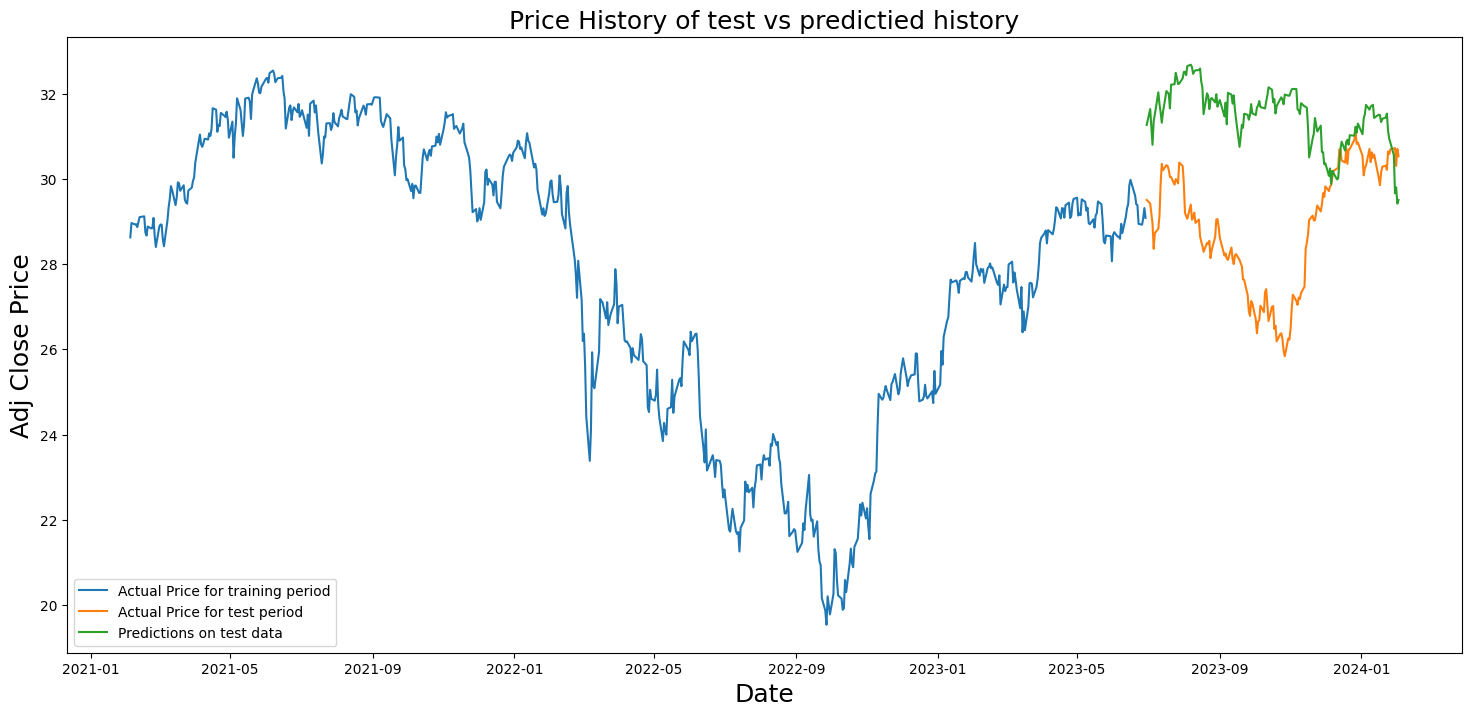

In [104]:
mse_model1 = mean_squared_error(predicitons, test_Y)
rmse_model1 = np.sqrt(mse_model1)

#visualize Results
def plot_results(stock, train, test, preds):
    test['predictions'] = preds
    
    plt.figure(figsize=(18,8))
    plt.plot(train)
    plt.plot(test)
    plt.title(f"Price History of {stock} vs predictied history", fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price', fontsize=18)
    plt.legend(['Actual Price for training period', 'Actual Price for test period', 'Predictions on test data'])
    
    plt.show()
    

print(type(dax_history))
train_history = dax_history[:train_data_len]
test_history = dax_history[train_data_len:]
plot_results("test", train_history, test_history, predicitons)